# Capsule Networks (CapsNets)

Based on the paper: [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829), by Sara Sabour, Nicholas Frosst and Geoffrey E. Hinton (NIPS 2017).

Inspired in part from Huadong Liao's implementation: [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow).

### TO DOs

- Add convolutional layers before capsules to get low level features (still getting 6\*6 feature maps) **DONE**
- Reduce batch size **DONE**
- Change validation set from last 104 (they may be all from one class) to a random sample **DONE**
- *Normalize* images **DONE**
- Reduce *learning rate* **DONE** from `learning_rate=.001` (default) to `learning_rate=.00001`
- Look into initialization/unnecessary *regularization*
- Increase number of capsules
- Change to plain CNN
- Change Dataset

# Imports

To support both Python 2 and Python 3:

In [1]:
from __future__ import division, print_function, unicode_literals

To plot pretty figures:

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

We will need NumPy and TensorFlow:

In [80]:
import numpy as np
import tensorflow as tf
import pandas as pd
from functools import reduce
import seaborn as sns
import dill

# Reproducibility

Let's reset the default graph, in case you re-run this notebook without restarting the kernel:

In [4]:
tf.reset_default_graph()

Let's set the random seeds so that this notebook always produces the same output:

In [5]:
np.random.seed(42)
tf.set_random_seed(42)

In [6]:
train = pd.read_json('../data/processed/train.json')

In [7]:
labels = train.is_iceberg

---

In [8]:
#test = pd.read_json('../data/processed/test.json')

---

And these are the corresponding labels:

Now let's build a Capsule Network to classify these images. Here's the overall architecture, enjoy the ASCII art! ;-)
Note: for readability, I left out two arrows: Labels → Mask, and Input Images → Reconstruction Loss.

```
                            Loss
                              ↑
                    ┌─────────┴─────────┐
      Labels → Margin Loss      Reconstruction Loss
                    ↑                   ↑
                  Length             Decoder
                    ↑                   ↑ 
             Digit Capsules ────Mask────┘
               ↖↑↗ ↖↑↗ ↖↑↗
             Primary Capsules
                    ↑      
               Input Images
```

We are going to build the graph starting from the bottom layer, and gradually move up, left side first. Let's go!

# Input Images

Let's start by creating a placeholder for the input images (28×28 pixels, 1 color channel = grayscale).

In [9]:
X = tf.placeholder(shape=[None, 75, 75, 1], dtype=tf.float32, name="X")

# Primary Capsules

The first layer will be composed of 32 maps of 6×6 capsules each, where each capsule will output an 8D activation vector:

In [10]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

To compute their outputs, we first apply two regular convolutional layers:

In [11]:
conv1_params = {
    "filters": 64, #was 256
    "kernel_size": 5,
    "strides": 1, #was 1
    "padding": "same", #was valid
    "activation": tf.nn.relu,
}

conv11_params = {
    "filters": 64, #was 256
    "kernel_size": 3, #was 5
    "strides": 1,
    "padding": "same",
    "activation": tf.nn.relu,
}

conv12_params = { #additional layer
    "filters": 128, #was 256
    "kernel_size": 3, #was 5
    "strides": 1,
    "padding": "same",
    "activation": tf.nn.relu,
}

conv13_params = { #additional layer
    "filters": 128,
    "kernel_size": 9,
    "strides": 3,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 6, #was 9
    "strides": 3, #was 2
    "padding": "valid",
    "activation": tf.nn.relu
}

In [12]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv11 = tf.layers.conv2d(conv1, name="conv11", **conv11_params)
conv12 = tf.layers.conv2d(conv11, name="conv12", **conv12_params)
conv13 = tf.layers.conv2d(conv12, name="conv13", **conv13_params)
conv2 = tf.layers.conv2d(conv13, name="conv2", **conv2_params)

Note: since we used a kernel size of 9 and no padding (for some reason, that's what `"valid"` means), the image shrunk by 9-1=8 pixels after each convolutional layer (28×28 to 20×20, then 20×20 to 12×12), and since we used a stride of 2 in the second convolutional layer, the image size was divided by 2. This is how we end up with 6×6 feature maps.

Next, we reshape the output to get a bunch of 8D vectors representing the outputs of the primary capsules. The output of `conv2` is an array containing 32×8=256 feature maps for each instance, where each feature map is 6×6. So the shape of this output is (_batch size_, 6, 6, 256). We want to chop the 256 into 32 vectors of 8 dimensions each. We could do this by reshaping to (_batch size_, 6, 6, 32, 8). However, since this first capsule layer will be fully connected to the next capsule layer, we can simply flatten the 6×6 grids. This means we just need to reshape to (_batch size_, 6×6×32, 8).

In [13]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

Now we need to squash these vectors. Let's define the `squash()` function, based on equation (1) from the paper:

$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

The `squash()` function will squash all vectors in the given array, along the given axis (by default, the last axis).

**Caution**, a nasty bug is waiting to bite you: the derivative of $\|\mathbf{s}\|$ is undefined when $\|\mathbf{s}\|=0$, so we can't just use `tf.norm()`, or else it will blow up during training: if a vector is zero, the gradients will be `nan`, so when the optimizer updates the variables, they will also become `nan`, and from then on you will be stuck in `nan` land. The solution is to implement the norm manually by computing the square root of the sum of squares plus a tiny epsilon value: $\|\mathbf{s}\| \approx \sqrt{\sum\limits_i{{s_i}^2}\,\,+ \epsilon}$.

In [14]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

Now let's apply this function to get the output $\mathbf{u}_i$ of each primary capsules $i$ :

In [15]:
caps1_output = squash(caps1_raw, name="caps1_output")

Great! We have the output of the first capsule layer. It wasn't too hard, was it? However, computing the next layer is where the fun really begins.

# Digit Capsules

To compute the output of the digit capsules, we must first compute the predicted output vectors (one for each primary / digit capsule pair). Then we can run the routing by agreement algorithm.

## Compute the Predicted Output Vectors

The digit capsule layer contains 10 capsules (one for each digit) of 16 dimensions each:

In [16]:
caps2_n_caps = 2
caps2_n_dims = 16

For each capsule $i$ in the first layer, we want to predict the output of every capsule $j$ in the second layer. For this, we will need a transformation matrix $\mathbf{W}_{i,j}$ (one for each pair of capsules ($i$, $j$)), then we can compute the predicted output $\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$ (equation (2)-right in the paper). Since we want to transform an 8D vector into a 16D vector, each transformation matrix $\mathbf{W}_{i,j}$ must have a shape of (16, 8).

To compute $\hat{\mathbf{u}}_{j|i}$ for every pair of capsules ($i$, $j$), we will use a nice feature of the `tf.matmul()` function: you probably know that it lets you multiply two matrices, but you may not know that it also lets you multiply higher dimensional arrays. It treats the arrays as arrays of matrices, and it performs itemwise matrix multiplication. For example, suppose you have two 4D arrays, each containing a 2×3 grid of matrices. The first contains matrices $\mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D}, \mathbf{E}, \mathbf{F}$ and the second contains matrices $\mathbf{G}, \mathbf{H}, \mathbf{I}, \mathbf{J}, \mathbf{K}, \mathbf{L}$. If you multiply these two 4D arrays using the `tf.matmul()` function, this is what you get:

$
\pmatrix{
\mathbf{A} & \mathbf{B} & \mathbf{C} \\
\mathbf{D} & \mathbf{E} & \mathbf{F}
} \times
\pmatrix{
\mathbf{G} & \mathbf{H} & \mathbf{I} \\
\mathbf{J} & \mathbf{K} & \mathbf{L}
} = \pmatrix{
\mathbf{AG} & \mathbf{BH} & \mathbf{CI} \\
\mathbf{DJ} & \mathbf{EK} & \mathbf{FL}
}
$

We can apply this function to compute $\hat{\mathbf{u}}_{j|i}$ for every pair of capsules ($i$, $j$) like this (recall that there are 6×6×32=1152 capsules in the first layer, and 10 in the second layer):

$
\pmatrix{
  \mathbf{W}_{1,1} & \mathbf{W}_{1,2} & \cdots & \mathbf{W}_{1,10} \\
  \mathbf{W}_{2,1} & \mathbf{W}_{2,2} & \cdots & \mathbf{W}_{2,10} \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{W}_{1152,1} & \mathbf{W}_{1152,2} & \cdots & \mathbf{W}_{1152,10}
} \times
\pmatrix{
  \mathbf{u}_1 & \mathbf{u}_1 & \cdots & \mathbf{u}_1 \\
  \mathbf{u}_2 & \mathbf{u}_2 & \cdots & \mathbf{u}_2 \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{u}_{1152} & \mathbf{u}_{1152} & \cdots & \mathbf{u}_{1152}
}
=
\pmatrix{
\hat{\mathbf{u}}_{1|1} & \hat{\mathbf{u}}_{2|1} & \cdots & \hat{\mathbf{u}}_{10|1} \\
\hat{\mathbf{u}}_{1|2} & \hat{\mathbf{u}}_{2|2} & \cdots & \hat{\mathbf{u}}_{10|2} \\
\vdots & \vdots & \ddots & \vdots \\
\hat{\mathbf{u}}_{1|1152} & \hat{\mathbf{u}}_{2|1152} & \cdots & \hat{\mathbf{u}}_{10|1152}
}
$


The shape of the first array is (1152, 10, 16, 8), and the shape of the second array is (1152, 10, 8, 1). Note that the second array must contain 10 identical copies of the vectors $\mathbf{u}_1$ to $\mathbf{u}_{1152}$. To create this array, we will use the handy `tf.tile()` function, which lets you create an array containing many copies of a base array, tiled in any way you want.

Oh, wait a second! We forgot one dimension: _batch size_. Say we feed 50 images to the capsule network, it will make predictions for these 50 images simultaneously. So the shape of the first array must be (50, 1152, 10, 16, 8), and the shape of the second array must be (50, 1152, 10, 8, 1). The first layer capsules actually already output predictions for all 50 images, so the second array will be fine, but for the first array, we will need to use `tf.tile()` to have 50 copies of the transformation matrices.

Okay, let's start by creating a trainable variable of shape (1, 1152, 10, 16, 8) that will hold all the transformation matrices. The first dimension of size 1 will make this array easy to tile. We initialize this variable randomly using a normal distribution with a standard deviation to 0.01.

In [17]:
init_sigma = 0.01

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

Now we can create the first array by repeating `W` once per instance:

In [18]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

That's it! On to the second array, now. As discussed earlier, we need to create an array of shape (_batch size_, 1152, 10, 8, 1), containing the output of the first layer capsules, repeated 10 times (once per digit, along the third dimension, which is axis=2). The `caps1_output` array has a shape of (_batch size_, 1152, 8), so we first need to expand it twice, to get an array of shape (_batch size_, 1152, 1, 8, 1), then we can repeat it 10 times along the third dimension:

In [19]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

Let's check the shape of the first array:

Good, and now the second:

Yes! Now, to get all the predicted output vectors $\hat{\mathbf{u}}_{j|i}$, we just need to multiply these two arrays using `tf.matmul()`, as explained earlier: 

In [20]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

Let's check the shape:

Perfect, for each instance in the batch (we don't know the batch size yet, hence the "?") and for each pair of first and second layer capsules (1152×10) we have a 16D predicted output column vector (16×1). We're ready to apply the routing by agreement algorithm!

## Routing by agreement

First let's initialize the raw routing weights $b_{i,j}$ to zero:

In [21]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

We will see why we need the last two dimensions of size 1 in a minute.

### Round 1

First, let's apply the softmax function to compute the routing weights, $\mathbf{c}_{i} = \operatorname{softmax}(\mathbf{b}_i)$ (equation (3) in the paper):

In [22]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

Now let's compute the weighted sum of all the predicted output vectors for each second-layer capsule, $\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$ (equation (2)-left in the paper):

In [23]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

There are a couple important details to note here:
* To perform elementwise matrix multiplication (also called the Hadamard product, noted $\circ$), we use the `tf.multiply()` function. It requires `routing_weights` and `caps2_predicted` to have the same rank, which is why we added two extra dimensions of size 1 to `routing_weights`, earlier.
* The shape of `routing_weights` is (_batch size_, 1152, 10, 1, 1) while the shape of `caps2_predicted` is (_batch size_, 1152, 10, 16, 1).  Since they don't match on the fourth dimension (1 _vs_ 16), `tf.multiply()` automatically _broadcasts_ the `routing_weights` 16 times along that dimension. If you are not familiar with broadcasting, a simple example might help:

  $ \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000} = \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000 \\ 10 & 100 & 1000} = \pmatrix{10 & 200 & 3000 \\ 40 & 500 & 6000} $

And finally, let's apply the squash function to get the outputs of the second layer capsules at the end of the first iteration of the routing by agreement algorithm, $\mathbf{v}_j = \operatorname{squash}(\mathbf{s}_j)$ :

In [24]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

Good! We have ten 16D output vectors for each instance, as expected.

### Round 2

First, let's measure how close each predicted vector $\hat{\mathbf{u}}_{j|i}$ is to the actual output vector $\mathbf{v}_j$ by computing their scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$.

* Quick math reminder: if $\vec{a}$ and $\vec{b}$ are two vectors of equal length, and $\mathbf{a}$ and $\mathbf{b}$ are their corresponding column vectors (i.e., matrices with a single column), then $\mathbf{a}^T \mathbf{b}$ (i.e., the matrix multiplication of the transpose of $\mathbf{a}$, and $\mathbf{b}$) is a 1×1 matrix containing the scalar product of the two vectors $\vec{a}\cdot\vec{b}$. In Machine Learning, we generally represent vectors as column vectors, so when we talk about computing the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$, this actually means computing ${\hat{\mathbf{u}}_{j|i}}^T \mathbf{v}_j$.

Since we need to compute the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ for each instance, and for each pair of first and second level capsules $(i, j)$, we will once again take advantage of the fact that `tf.matmul()` can multiply many matrices simultaneously. This will require playing around with `tf.tile()` to get all dimensions to match (except for the last 2), just like we did earlier. So let's look at the shape of `caps2_predicted`, which holds all the predicted output vectors $\hat{\mathbf{u}}_{j|i}$ for each instance and each pair of capsules:

To get these shapes to match, we just need to tile the `caps2_output_round_1` array 1152 times (once per primary capsule) along the second dimension:

In [25]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

And now we are ready to call `tf.matmul()` (note that we must tell it to transpose the matrices in the first array, to get ${\hat{\mathbf{u}}_{j|i}}^T$ instead of $\hat{\mathbf{u}}_{j|i}$):

In [26]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

We can now update the raw routing weights $b_{i,j}$ by simply adding the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ we just computed: $b_{i,j} \gets b_{i,j} + \hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ (see Procedure 1, step 7, in the paper).

In [27]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

The rest of round 2 is the same as in round 1:

In [28]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

We could go on for a few more rounds, by repeating exactly the same steps as in round 2, but to keep things short, we will stop here:

In [29]:
caps2_output = caps2_output_round_2

# Estimated Class Probabilities (Length)

The lengths of the output vectors represent the class probabilities, so we could just use `tf.norm()` to compute them, but as we saw when discussing the squash function, it would be risky, so instead let's create our own `safe_norm()` function:

In [30]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [31]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

To predict the class of each instance, we can just select the one with the highest estimated probability. To do this, let's start by finding its index using `tf.argmax()`:

In [32]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

Let's look at the shape of `y_proba_argmax`:

That's what we wanted: for each instance, we now have the index of the longest output vector. Let's get rid of the last two dimensions by using `tf.squeeze()` which removes dimensions of size 1. This gives us the capsule network's predicted class for each instance:

In [33]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

Okay, we are now ready to define the training operations, starting with the losses.

# Labels

First, we will need a placeholder for the labels:

In [34]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

# Margin loss

The paper uses a special margin loss to make it possible **to detect two or more different digits in each image**:

$ L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$

* $T_k$ is equal to 1 if the digit of class $k$ is present, or 0 otherwise.
* In the paper, $m^{+} = 0.9$, $m^{-} = 0.1$ and $\lambda = 0.5$.
* Note that there was an error in the video (at 15:47): the max operations are squared, not the norms. Sorry about that.

In [35]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

Since `y` will contain the digit classes, from 0 to 9, to get $T_k$ for every instance and every class, we can just use the `tf.one_hot()` function:

In [36]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

A small example should make it clear what this does:

Now let's compute the norm of the output vector for each output capsule and each instance. First, let's verify the shape of `caps2_output`:

The 16D output vectors are in the second to last dimension, so let's use the `safe_norm()` function with `axis=-2`:

In [37]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

Now let's compute $\max(0, m^{+} - \|\mathbf{v}_k\|)^2$, and reshape the result to get a simple matrix of shape (_batch size_, 10):

In [38]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 2),
                           name="present_error")

Next let's compute $\max(0, \|\mathbf{v}_k\| - m^{-})^2$ and reshape it:

In [39]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 2),
                          name="absent_error")

We are ready to compute the loss for each instance and each digit:

In [40]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

Now we can sum the digit losses for each instance ($L_0 + L_1 + \cdots + L_9$), and compute the mean over all instances. This gives us the final margin loss:

In [41]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

# Reconstruction

Now let's add a decoder network on top of the capsule network. It is a regular 3-layer fully connected neural network which will learn to reconstruct the input images based on the output of the capsule network. This will force the capsule network to preserve all the information required to reconstruct the digits, across the whole network. This constraint regularizes the model: it reduces the risk of overfitting the training set, and it helps generalize to new digits.

## Mask

The paper mentions that during training, instead of sending all the outputs of the capsule network to the decoder network, we must send only the output vector of the capsule that corresponds to the target digit. All the other output vectors must be masked out. At inference time, we must mask all output vectors except for the longest one, i.e., the one that corresponds to the predicted digit. You can see this in the paper's figure 2 (at 18:15 in the video): all output vectors are masked out, except for the reconstruction target's output vector.

We need a placeholder to tell TensorFlow whether we want to mask the output vectors based on the labels (`True`) or on the predictions (`False`, the default):

In [42]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

Now let's use `tf.cond()` to define the reconstruction targets as the labels `y` if `mask_with_labels` is `True`, or `y_pred` otherwise.

In [43]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

Note that the `tf.cond()` function expects the if-True and if-False tensors to be passed _via_ functions: these functions will be called just once during the graph construction phase (not during the execution phase), similar to `tf.while_loop()`. This allows TensorFlow to add the necessary operations to handle the conditional evaluation of the if-True or if-False tensors. However, in our case, the tensors `y` and `y_pred` are already created by the time we call `tf.cond()`, so unfortunately TensorFlow will consider both `y` and `y_pred` to be dependencies of the `reconstruction_targets` tensor. The `reconstruction_targets` tensor will end up with the correct value, but:
1. whenever we evaluate a tensor that depends on `reconstruction_targets`, the `y_pred` tensor will be evaluated (even if `mask_with_layers` is `True`). This is not a big deal because computing `y_pred` adds no computing overhead during training, since we need it anyway to compute the margin loss. And during testing, if we are doing classification, we won't need reconstructions, so `reconstruction_targets` won't be evaluated at all.
2. we will always need to feed a value for the `y` placeholder (even if `mask_with_layers` is `False`). This is a bit annoying, but we can pass an empty array, because TensorFlow won't use it anyway (it just does not know it yet when it checks for dependencies).

Now that we have the reconstruction targets, let's create the reconstruction mask. It should be equal to 1.0 for the target class, and 0.0 for the other classes, for each instance. For this we can just use the `tf.one_hot()` function:

In [44]:
 reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

Mmh, its shape is (_batch size_, 1, 10, 16, 1). We want to multiply it by the `reconstruction_mask`, but the shape of the `reconstruction_mask` is (_batch size_, 10). We must reshape it to (_batch size_, 1, 10, 1, 1) to make multiplication possible:

In [45]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

At last! We can apply the mask:

In [46]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

One last reshape operation to flatten the decoder's inputs:

In [47]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

This gives us an array of shape (_batch size_, 160):

## Decoder

Now let's build the decoder. It's quite simple: two dense (fully connected) ReLU layers followed by a dense output sigmoid layer:

In [48]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 75 * 75

In [49]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

## Reconstruction Loss

Now let's compute the reconstruction loss. It is just the squared difference between the input image and the reconstructed image:

In [50]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_sum(squared_difference,
                                    name="reconstruction_loss")

## Final Loss

The final loss is the sum of the margin loss and the reconstruction loss (scaled down by a factor of 0.0005 to ensure the margin loss dominates training):

In [51]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

# Final Touches

## Accuracy

To measure our model's accuracy, we need to count the number of instances that are properly classified. For this, we can simply compare `y` and `y_pred`, convert the boolean value to a float32 (0.0 for False, 1.0 for True), and compute the mean over all the instances:

In [52]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

## Training Operations

The paper mentions that the authors used the Adam optimizer with TensorFlow's default parameters:

In [53]:
optimizer = tf.train.AdamOptimizer(learning_rate=.0001)
training_op = optimizer.minimize(loss, name="training_op")

## Init and Saver

And let's add the usual variable initializer, as well as a `Saver`:

In [54]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And... we're done with the construction phase! Please take a moment to celebrate. :)

# Training

Training our capsule network is pretty standard. For simplicity, we won't do any fancy hyperparameter tuning, dropout or anything, we will just run the training operation over and over again, displaying the loss, and at the end of each epoch, measure the accuracy on the validation set, display it, and save the model if the validation loss is the lowest seen found so far (this is a basic way to implement early stopping, without actually stopping). Hopefully the code should be self-explanatory, but here are a few details to note:
* if a checkpoint file exists, it will be restored (this makes it possible to interrupt training, then restart it later from the last checkpoint),
* we must not forget to feed `mask_with_labels=True` during training,
* during testing, we let `mask_with_labels` default to `False` (but we still feed the labels since they are required to compute the accuracy),
* the images loaded _via_ `mnist.train.next_batch()` are represented as `float32` arrays of shape \[784\], but the input placeholder `X` expects a `float32` array of shape \[28, 28, 1\], so we must reshape the images before we feed them to our model,
* we evaluate the model's loss and accuracy on the full validation set (5,000 instances). To view progress and support systems that don't have a lot of RAM, the code evaluates the loss and accuracy on one batch at a time, and computes the mean loss and mean accuracy at the end.

*Warning*: if you don't have a GPU, training will take a very long time (at least a few hours). With a GPU, it should take just a few minutes per epoch (e.g., 6 minutes on an NVidia GeForce GTX 1080Ti).

**For now we're using only *one* of the two channels/bands from the Statoil dataset pictures**

Normalizing images

---

In [54]:
#img_array = np.array(train['band_1'][0]).reshape(75,75)
#img_array_norm = (img_array - img_array.min()) / (img_array.max() - img_array.min())

In [55]:
#img_array

array([[-27.878361, -27.15416 , -28.668615, ..., -25.573483, -26.488674,
        -30.507013],
       [-28.66853 , -27.878401, -27.508776, ..., -26.488632, -28.671562,
        -31.594166],
       [-28.66853 , -27.15416 , -25.865042, ..., -27.157106, -27.881393,
        -32.837124],
       ..., 
       [-29.092905, -28.669163, -30.504612, ..., -30.011005, -25.868538,
        -26.489265],
       [-31.591682, -27.878992, -28.669205, ..., -27.512272, -26.817074,
        -27.512358],
       [-29.092905, -26.814081, -27.154791, ..., -26.817032, -27.881983,
        -28.268127]])

In [56]:
#img_array_norm

array([[ 0.27193414,  0.29099295,  0.25113701, ...,  0.33259165,
         0.30850655,  0.20275585],
       [ 0.25113924,  0.27193308,  0.28166051, ...,  0.30850766,
         0.25105945,  0.17414523],
       [ 0.25113924,  0.29099295,  0.32491869, ...,  0.29091542,
         0.27185434,  0.14143428],
       ..., 
       [ 0.23997096,  0.25112259,  0.20281904, ...,  0.21580931,
         0.32482668,  0.308491  ],
       [ 0.1742106 ,  0.27191753,  0.25112148, ...,  0.28156851,
         0.29986404,  0.28156624],
       [ 0.23997096,  0.29994281,  0.29097634, ...,  0.29986515,
         0.27183882,  0.26167666]])

---

In [55]:
train['band_1'] = [(np.array(img).reshape(75,75) - \
                    np.array(img).reshape(75,75).min())/(np.array(img).reshape(75,75).max() - \
                                                         np.array(img).reshape(75,75).min()) \
                   for img in train['band_1']]
#img_array_norm = (img_array - img_array.min()) / (img_array.max() - img_array.min())

In [56]:
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
#x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#X_train = np.concatenate([x_band1[:, :, :, np.newaxis], x_band2[:, :, :, np.newaxis]], axis=-1)
y_train_val = np.array(labels, dtype = np.float32).reshape(train.shape[0], 1)

---

In [57]:
#test.head()

In [58]:
#x_test_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])

In [59]:
#len(test[:1].band_1[0]) == 75**2

In [60]:
#testing = x_test_band1

---

---

### Train/Validation Split

Possibly put together the TT split code below into a function

In [61]:
np.random.seed(42)
validation_indices = np.random.choice(x_band1.shape[0], 104, replace = False)
training_indices = list(set(np.arange(x_band1.shape[0])) - set(validation_indices))

In [62]:
training = x_band1[training_indices, ]
validation = x_band1[validation_indices, ]

In [63]:
y_train = np.array(labels[training_indices], dtype = np.float32).reshape(-1, 1)
y_validation = np.array(labels[validation_indices], dtype = np.float32).reshape(-1, 1)

---

In [64]:
reduce(sum, y_validation)[0]

59.0

In [75]:
n_epochs = 5 #+20 # total epochs so far
batch_size = 10
restore_checkpoint = True #False to start from scratch

n_iterations_per_epoch = training.shape[0] // batch_size
n_iterations_validation = validation.shape[0] // batch_size
best_loss_val = np.infty
checkpoint_path = "./faster_lr_saves/my_faster_capsule_network"

In [76]:
with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    
    avg_loss_adamoptimizer_0001_ = np.zeros(n_epochs)
    avg_acc_adamoptimizer_0001_ = np.zeros(n_epochs)
    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch = training[(batch_size*(iteration-1)):(batch_size*iteration), ]
            y_batch = y_train[(batch_size*(iteration-1)):(batch_size*iteration), ]
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 75, 75, 1]),
                           y: y_batch.reshape(y_batch.shape[0]),
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch = validation[(batch_size*(iteration-1)):(batch_size*iteration),]
            y_batch = y_validation[(batch_size*(iteration-1)):(batch_size*iteration),]
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 75, 75, 1]),
                               y: y_batch.reshape(y_batch.shape[0])})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        avg_loss_adamoptimizer_0001_[epoch] = loss_val
        avg_acc_adamoptimizer_0001_[epoch] = acc_val
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

INFO:tensorflow:Restoring parameters from ./faster_lr_saves/my_faster_capsule_network
Epoch: 1  Val accuracy: 66.0000%  Loss: 0.423174 (improved)
Epoch: 2  Val accuracy: 68.0000%  Loss: 0.418249 (improved)
Epoch: 3  Val accuracy: 70.0000%  Loss: 0.411471 (improved)
Epoch: 4  Val accuracy: 70.0000%  Loss: 0.408053 (improved)
Epoch: 5  Val accuracy: 71.0000%  Loss: 0.404427 (improved)


In [ ]:
avg_loss_adamoptimizer_0001 = np.append(avg_loss_adamoptimizer_0001, avg_loss_adamoptimizer_0001_)
avg_acc_adamoptimizer_0001 = np.append(avg_acc_adamoptimizer_0001, avg_acc_adamoptimizer_0001_)

In [81]:
dill.dump(avg_loss_adamoptimizer_0001, open('avg_loss_adamoptimizer_0001.dill', 'wb'))
dill.dump(avg_acc_adamoptimizer_0001, open('avg_acc_adamoptimizer_0001.dill', 'wb'))

In [ ]:
avg_loss_adamoptimizer_0001 = dill.load(open('avg_loss_adamoptimizer_0001.dill', 'rb'))
avg_acc_adamoptimizer_0001 = dill.load(open('avg_acc_adamoptimizer_0001.dill', 'rb'))

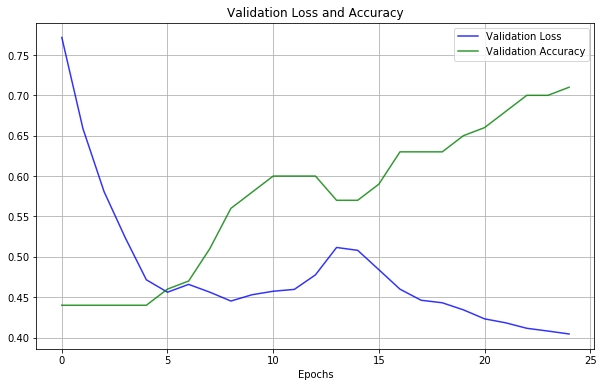

In [79]:
plt.figure(figsize=(10,6))
plt.plot(avg_loss_adamoptimizer_0001, color='blue', alpha=0.8, label='Validation Loss')
plt.plot(avg_acc_adamoptimizer_0001, color='green', alpha=0.8, label='Validation Accuracy')
#plt.plot(avg_loss_adam, color='black', alpha=0.8, label='Adam')
plt.title("Validation Loss and Accuracy")
plt.xlabel("Epochs")
#plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

---

# Evaluation

In [93]:
n_iterations_test = testing.shape[0] // batch_size

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch = testing[(batch_size*(iteration-1)):(batch_size*iteration), ]
        y_batch = y_train[(batch_size*(iteration-1)):(batch_size*iteration), ]
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

We reach 99.43% accuracy on the test set. Pretty nice. :)

# Predictions

Now let's make some predictions! We first fix a few images from the test set, then we start a session, restore the trained model, evaluate `caps2_output` to get the capsule network's output vectors, `decoder_output` to get the reconstructions, and `y_pred` to get the class predictions:

In [ ]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

Note: we feed `y` with an empty array, but TensorFlow will not use it, as explained earlier.

And now let's plot the images and their labels, followed by the corresponding reconstructions and predictions:

In [ ]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()


The predictions are all correct, and the reconstructions look great. Hurray!

# Interpreting the Output Vectors

Let's tweak the output vectors to see what their pose parameters represent.

First, let's check the shape of the `cap2_output_value` NumPy array:

In [ ]:
caps2_output_value.shape

Let's create a function that will tweak each of the 16 pose parameters (dimensions) in all output vectors. Each tweaked output vector will be identical to the original output vector, except that one of its pose parameters will be incremented by a value varying from -0.5 to 0.5. By default there will be 11 steps (-0.5, -0.4, ..., +0.4, +0.5). This function will return an array of shape (_tweaked pose parameters_=16, _steps_=11, _batch size_=5, 1, 10, 16, 1):

In [ ]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

Let's compute all the tweaked output vectors and reshape the result to (_parameters_×_steps_×_instances_, 1, 10, 16, 1) so we can feed the array to the decoder:

In [ ]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

Now let's feed these tweaked output vectors to the decoder and get the reconstructions it produces:

In [ ]:
tweak_labels = np.tile(mnist.test.labels[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

Let's reshape the decoder's output so we can easily iterate on the output dimension, the tweak steps, and the instances:

In [ ]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])

Lastly, let's plot all the reconstructions, for the first 3 output dimensions, for each tweaking step (column) and each digit (row):

In [ ]:
for dim in range(3):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()

# Conclusion

I tried to make the code in this notebook as flat and linear as possible, to make it easier to follow, but of course in practice you would want to wrap the code in nice reusable functions and classes. For example, you could try implementing your own `PrimaryCapsuleLayer`, and `DenseRoutingCapsuleLayer` classes, with parameters for the number of capsules, the number of routing iterations, whether to use a dynamic loop or a static loop, and so on. For an example a modular implementation of Capsule Networks based on TensorFlow, take a look at the [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow) project.

That's all for today, I hope you enjoyed this notebook!